<a href="https://colab.research.google.com/github/SG60/2021-multi-group-piece/blob/main/Tempos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic Setup

In [27]:
# Install black + magic_command: %%black
!pip install blackcellmagic

In [28]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

from sympy import init_session
init_session()

IPython console for SymPy 1.7.1 (Python 3.7.10-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.7.1/



In [3]:
# Tool for custom rounding
from bisect import bisect_left

class CustomRound:

    def __init__(self,iterable):
        self.data = sorted(iterable)

    def __call__(self,x):
        data = self.data
        ndata = len(data)
        idx = bisect_left(data,x)
        if idx <= 0:
            return data[0]
        elif idx >= ndata:
            return data[ndata-1]
        x0 = data[idx-1]
        x1 = data[idx]
        if abs(x-x0) < abs(x-x1):
            return x0
        return x1

custom_round_values_base = [0, 1/5,1/4,1/3,2/5,1/2,3/5,2/3,3/4,4/5]
custom_round_values = [i+j for i in range(20) for j in custom_round_values_base]
custom_round = CustomRound(custom_round_values)

#Actual Stuff

##Up Ramp

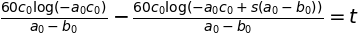

In [4]:
a, a1, b, b1, c, c1, s, t = symbols('a:2 b:2 c:2 s t')
# a = start tempo of ramp
# b = end tempo of ramp
# c = length of ramp in beats
# s = beat we are interested in
# t = timecode of that beat
tempoeq = Eq(integrate(1/(a/60+(x/c)*(b/60-a/60)),(x,0,s)),t)
tempoeq

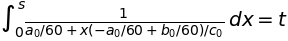

In [5]:
Eq(Integral(1/(a/60+(x/c)*(b/60-a/60)),(x,0,s)),t)

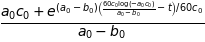

In [6]:
s_solved = solveset(tempoeq,s).args[0]
display(s_solved)

In [7]:
#@title Values for steady part
number_of_beats = 13 #@param {type:"integer"}
steady_tempo = 96 #@param {type:"integer"}

In [8]:
#@title Values for ramp part
start_tempo = 96 #@param {type:"integer"}
end_tempo = 240 #@param {type:"integer"}
length_in_beats = 20 #@param {type:"integer"}

In [9]:
temposteady = steady_tempo
beatlength = S(60)/steady_tempo
#beats = [0, S(1)/3, 2, 4]
beats = range(number_of_beats)
beattimecodes_up_ramp = [beatlength*i for i in beats]
outbeats = [s_solved.n(6,{a: start_tempo, b: end_tempo, c: length_in_beats, t: i},chop=True) for i in beattimecodes_up_ramp]
for i in range(len(outbeats)):
  print(beats[i], outbeats[i])

0 0
1 1.03846
2 2.15779
3 3.36430
4 4.66478
5 6.06655
6 7.57750
7 9.20612
8 10.9616
9 12.8538
10 14.8933
11 17.0917
12 19.4614


In [10]:
print(1/5,1/4,1/3,2/5,1/2,3/5,2/3,3/4,4/5)

0.2 0.25 0.3333333333333333 0.4 0.5 0.6 0.6666666666666666 0.75 0.8


In [11]:
display(beattimecodes_up_ramp[12].n())
display([i.n() for i in beattimecodes_up_ramp])

In [12]:
# Timecode at beat 20
solveset(tempoeq.subs({a: start_tempo, b: end_tempo, c: length_in_beats, s:20}),t).n(6)

##Down Ramp

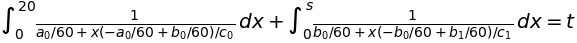

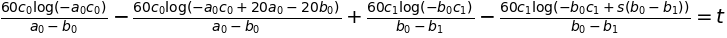

In [13]:
# b1 = end tempo of down ramp
# c1 = number of beats in down ramp
tempoeq2_not_done = Eq(Integral(1/(a/60+(x/c)*(b/60-a/60)),(x,0,20))+Integral(1/(b/60+(x/c1)*(b1/60-b/60)),(x,0,s)),t)
display(tempoeq2_not_done)
tempoeq2 = tempoeq2_not_done.doit()
display(tempoeq2)

In [29]:
%%black
s2_solved = solveset(tempoeq2,s).args[0]
#display(s2_solved.args[0])
s2_solved_subbed = s2_solved.subs({a: 96, b: 240, c: 20, b1: 60, c1: 16})
display(s2_solved_subbed)
# values for slowing down ramp
beats_down_ramp = range(13,floor(16/beatlength))
beattimecodes_down_ramp = [beatlength*i for i in beats_down_ramp]
display([i.n() for i in beattimecodes_down_ramp])
outbeats_down_ramp = [s2_solved_subbed.n(6,{t: i},chop=True) for i in beattimecodes_down_ramp]
for i in range(len(outbeats_down_ramp)):
  print(beats_down_ramp[i],
        outbeats_down_ramp[i],
        custom_round(outbeats_down_ramp[i])
        ) # beat values (from start of ramp)

In [15]:
#total length of both ramps in seconds:
solveset(tempoeq2,t).args[0].subs({a: 96, b: 240, c: 20, b1: 60, c1: 16, s:16}).n(6)

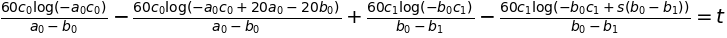

In [22]:
def ramp(start_tempo,end_tempo,total_beats,bound_beat):
  '''This integral is equal to the timecode at the bound_beat.'''
  return integrate(1/(start_tempo/60+(x/total_beats)*(S(end_tempo)/60-start_tempo/60)),(x,0,bound_beat))

tempoeq2_version_using_ramp = Eq(ramp(a,b,c,20) + ramp(b,b1,c1,s), t)
display(tempoeq2_version_using_ramp) # this is equal to tempoeq2